In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm
from PIL import Image
from PIL import ImageDraw, ImageFont
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from datasets import load_dataset 
from datasets import load_metric
from datasets.features import ClassLabel
from transformers.data.data_collator import default_data_collator
from transformers import AutoProcessor
from transformers import LayoutLMv3ForTokenClassification
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForTokenClassification
DIR = os.getcwd()


In [2]:
!git config --global user.email "andre002wp@gmail.com"
!git config --global user.name "andre002wp"

In [3]:
dataset = load_dataset("Theivaprakasham/wildreceipt")
example = dataset["train"][0]
example["image_path"]
words, bboxes, ner_tags = example["words"], example["bboxes"], example["ner_tags"]
print(words)
print(bboxes)
print(ner_tags)

Found cached dataset wildreceipt (C:/Users/asus/.cache/huggingface/datasets/Theivaprakasham___wildreceipt/WildReceipt/1.0.0/643cda6d4cd0ff2e8d7ee57e4872c509b29060f1df957b5a59e66d9940b9594e)


  0%|          | 0/2 [00:00<?, ?it/s]

['SAFEWAY', 'TM', 'ATOREMGRTOMMILAZZO', '703-777-5833', 'THANKYOUFORSHOPPINGWITHUS!', 'GROCERY', 'BCCHOCCUPCAKES', 'ACNSPRYFRTSHAPE', 'Regprice', 'Cardsavings', 'MfrCpn', 'MultipliedCpn', 'DULCEDELECHECHE', 'Regprice', 'CardSavings', 'MfrCpn', 'MuitipliedCpn', 'MULTIGRAINCHEERIO', 'RegPrice', 'CardSavings', 'MfrCpn', 'MuitieliedCpn', 'PROGRESSOR&HSTK', 'RegPrice', 'CardSavings', 'REFRIG/FROZEN', '3.99', '.49', '3.79', '1.80-', '.75-', '.75-', '1.99', '4.19', '1.20-', '.50-', '.50-', '1.50', '3.99', '1.49-', '.50-', '.50-', '2.00', '2.69', '.69-', '1OIY', 'PLSBRYBSCTSANDWI', 'TOTINOSPZASTOFFE', 'RegPrice', '', '', '3.50', '3.49', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
[[343, 86, 585, 158], [655, 163, 671, 175], [334, 166, 520, 199], [566, 185, 675, 213], [360, 191, 635, 235], [452, 295, 525, 322], [296, 328, 458, 360], [293, 350, 477, 388], [291, 373, 371, 402], [289, 398, 411, 430], [286, 422, 358, 448], [284, 446, 428, 481], [283, 470, 468, 509], [280, 494, 363, 520], [278, 519, 402, 551]

## Exploration

In [4]:
dataset["train"]

Dataset({
    features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
    num_rows: 1267
})

In [5]:
dataset["test"]

Dataset({
    features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
    num_rows: 472
})

## random test

In [4]:
def normalize_bbox(bbox, size):
    return [
        int(bbox[0] * 1000 / size[1]),
        int(bbox[1] * 1000 / size[0]),
        int(bbox[2] * 1000 / size[1]),
        int(bbox[3] * 1000 / size[0]),
    ]

def unnormalize_bbox(bbox, size):
     return [
        int(bbox[0] * size[1] / 1000),
        int(bbox[1] * size[0] / 1000),
        int(bbox[2] * size[1] / 1000),
        int(bbox[3] * size[0] / 1000),
    ]


def fix_box(bbox, size):
    return [
        int(bbox[0] * size[1] / 1000),
        int(bbox[1] * size[0] / 1000),
        int(bbox[2] * size[1] / 1000),
        int(bbox[3] * size[0] / 1000),
    ]

label2color = {
    "Date_key": 'red',
    "Date_value": 'blue',
    "Ignore": 'orange',
    "Others": 'orange',
    "Prod_item_key": 'red',
    "Prod_item_value": 'green',
    "Prod_price_key": 'red',
    "Prod_price_value": 'blue',
    "Prod_quantity_key": 'red',
    "Prod_quantity_value": 'green',
    "Store_addr_key": 'red',
    "Store_addr_value": 'blue',
    "Store_name_key": 'red',
    "Store_name_value": 'blue',
    "Subtotal_key": 'red',
    "Subtotal_value": 'blue',
    "Tax_key": 'red',
    "Tax_value": 'green',
    "Tel_key": 'red',
    "Tel_value": 'green',
    "Time_key": 'red',
    "Time_value": 'green',
    "Tips_key": 'red',
    "Tips_value": 'green',
    "Total_key": 'red',
    "Total_value": 'blue'
  }

In [62]:
unique_ner_tags = set()
on_list = []
for example in dataset["train"]:
    for ner_tag in example["ner_tags"]:
        if ner_tag not in unique_ner_tags:
            print(ner_tag," on ",example["id"])
            on_list.append(example["image_path"])
            unique_ner_tags.add(ner_tag)
unique_ner_tags

1  on  0
25  on  0
5  on  0
11  on  0
15  on  0
14  on  0
0  on  0
3  on  1
18  on  1
20  on  1
24  on  1
17  on  1
19  on  1
23  on  1
7  on  1
9  on  1
13  on  2
22  on  5
21  on  5
12  on  7
8  on  7
6  on  8
10  on  10
16  on  10
2  on  71
4  on  386


{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25}

In [8]:
on_list = list(set(on_list))
on_list

['C:\\Users\\asus\\.cache\\huggingface\\datasets\\downloads\\extracted\\fed58dc3b18e734a659061bf972b2f62107167b090962f4aa1c34eedbbff1719\\wildreceipt\\image_files\\Image_18\\12\\1bf58322901e12bd7a7b943078b20e5aa931b28a.jpeg',
 'C:\\Users\\asus\\.cache\\huggingface\\datasets\\downloads\\extracted\\fed58dc3b18e734a659061bf972b2f62107167b090962f4aa1c34eedbbff1719\\wildreceipt\\image_files\\Image_17\\12\\01a645e7b7a5179f2fc6c3d22242a43b67eb92ae.jpeg',
 'C:\\Users\\asus\\.cache\\huggingface\\datasets\\downloads\\extracted\\fed58dc3b18e734a659061bf972b2f62107167b090962f4aa1c34eedbbff1719\\wildreceipt\\image_files\\Image_73\\5\\f0c0a70f0a46701727479f0c06929db75f697931.jpeg',
 'C:\\Users\\asus\\.cache\\huggingface\\datasets\\downloads\\extracted\\fed58dc3b18e734a659061bf972b2f62107167b090962f4aa1c34eedbbff1719\\wildreceipt\\image_files\\Image_76\\6\\829116cafaaa5501ff4446d1368f8fa6fb6ce0a7.jpeg',
 'C:\\Users\\asus\\.cache\\huggingface\\datasets\\downloads\\extracted\\fed58dc3b18e734a659061bf97

In [35]:
test_img = Image.open(on_list[5])
test_box = [unnormalize_bbox(box, (test_img.size[1],test_img.size[0])) for box in example["bboxes"]]

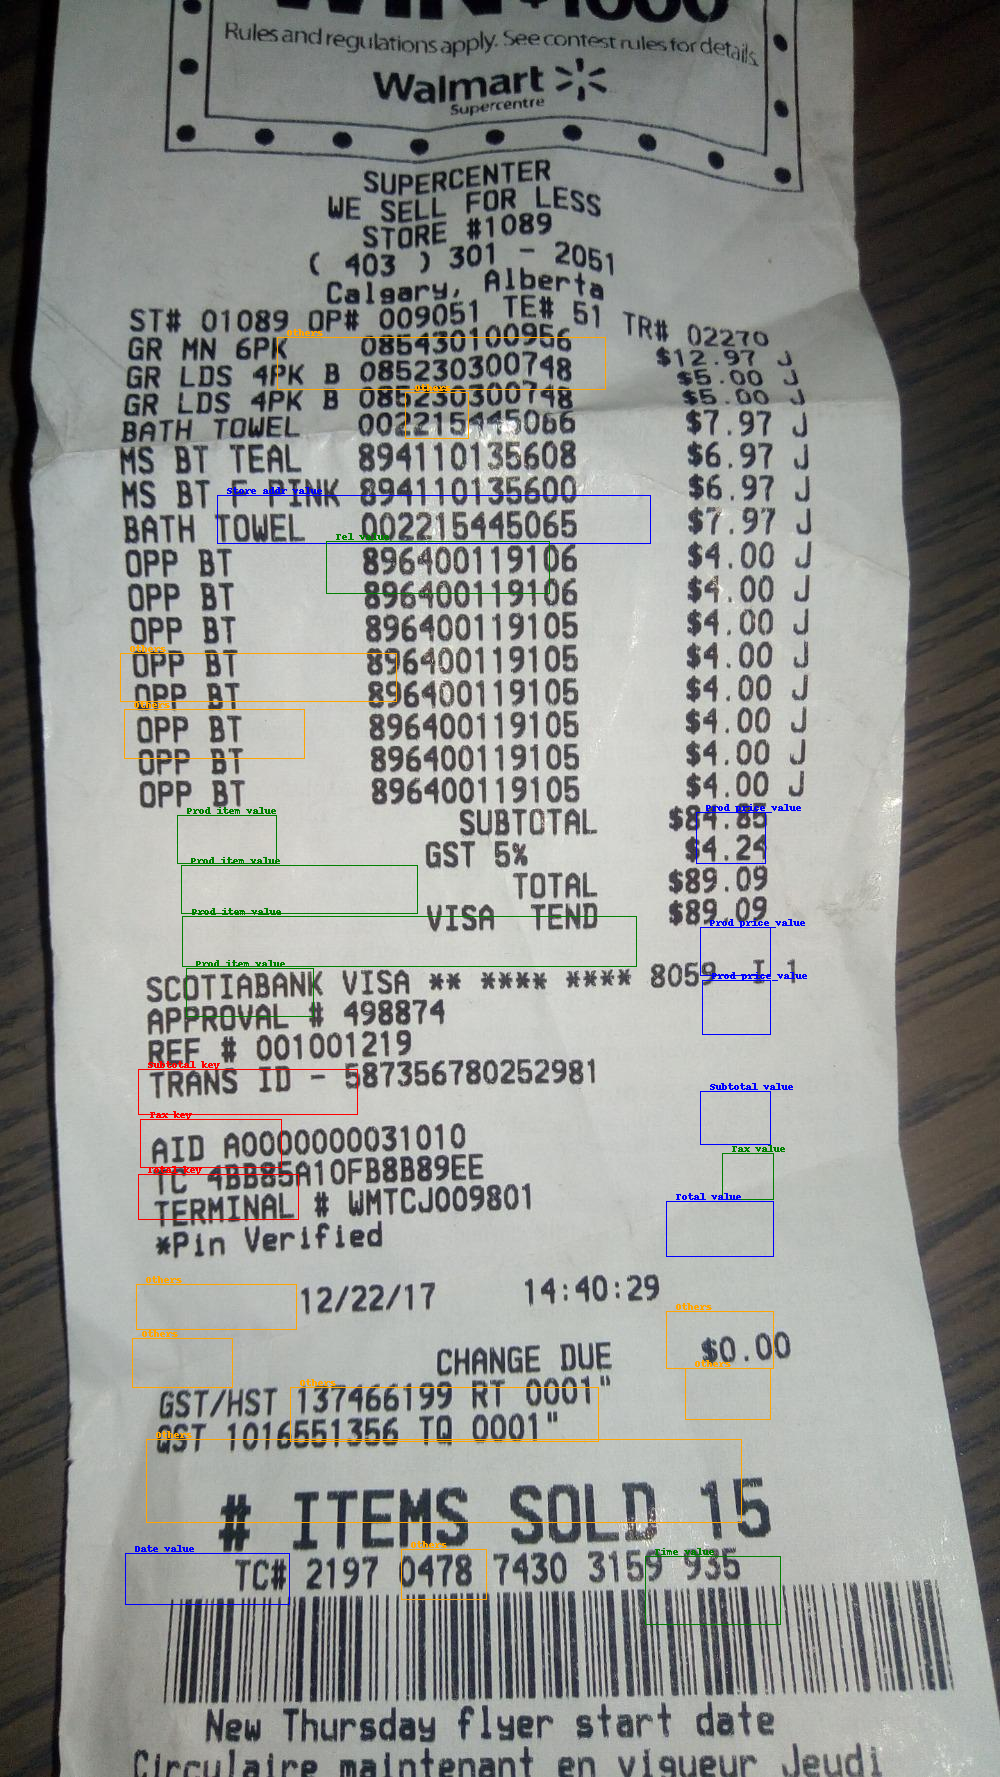

In [36]:
draw = ImageDraw.Draw(test_img)
font = ImageFont.load_default()
labels = {k: v for k,v in enumerate(dataset["train"].features["ner_tags"].feature.names)}

for tag, box in zip(example["ner_tags"], test_box):
    image_labels = labels[tag]
    draw.rectangle(box, outline=label2color[image_labels])
    draw.text((box[0]+10, box[1]-10), text=image_labels, fill=label2color[image_labels], font=font)
test_img

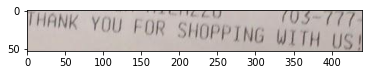

(1200, 1600, 3)


[576, 229, 1016, 282]

In [16]:
img_read = cv2.imread(example["image_path"])
img_read = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
if img_read is None:
    raise Exception(f"Image {example['image_path']} not found")

xx = [360, 191, 635, 235]
xx = unnormalize_bbox(xx, img_read.shape)
plt.imshow(img_read[xx[1]:xx[3],xx[0]:xx[2]])
plt.show()
print(img_read.shape)
xx

## Continue

In [5]:
label_primary_names = ['Ignore',
                    'Store_name_value',
                    'Store_name_key',
                    'Store_addr_value',
                    'Store_addr_key',
                    'Tel_value',
                    'Tel_key',
                    'Date_value',
                    'Date_key',
                    'Time_value',
                    'Time_key',
                    'Prod_item_value',
                    'Prod_item_key',
                    'Prod_quantity_value',
                    'Prod_quantity_key',
                    'Prod_price_value',
                    'Prod_price_key',
                    'Subtotal_value',
                    'Subtotal_key',
                    'Tax_value',
                    'Tax_key',
                    'Tips_value',
                    'Tips_key',
                    'Total_value',
                    'Total_key',
                    'Others']

In [6]:
label_new_names = ['Ignore', 
                    'Store_name_value',
                    'Date_value',
                    'Time_value',
                    'Prod_item_key',
                    'Prod_item_value',
                    'Prod_quantity_key',
                    'Prod_quantity_value',
                    'Prod_price_key',
                    'Prod_price_value',
                    'Subtotal_key',
                    'Subtotal_value',
                    'Total_key',
                    'Total_value',
                    'Others']

In [7]:
excluded_labels = [tag for tag in label_primary_names if tag not in label_new_names]

In [335]:
features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image_path"

def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

label_list = label_new_names
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}
id2label

{0: 'Ignore',
 1: 'Store_name_value',
 2: 'Date_value',
 3: 'Time_value',
 4: 'Prod_item_key',
 5: 'Prod_item_value',
 6: 'Prod_quantity_key',
 7: 'Prod_quantity_value',
 8: 'Prod_price_key',
 9: 'Prod_price_value',
 10: 'Subtotal_key',
 11: 'Subtotal_value',
 12: 'Total_key',
 13: 'Total_value',
 14: 'Others'}

In [293]:
from datasets import Dataset
new_train_data = []
new_test_data = []

In [11]:
# Secondary Dataset
for example in dataset["train"]:
    new_ner_tags = [label_primary_names[tag] for tag in example["ner_tags"]]
    new_ner_tags = [label2id[tag] if tag not in excluded_labels else 14 for tag in new_ner_tags]
    new_train_data.append({"id": example["id"],"words": example["words"], "bboxes": example["bboxes"], "ner_tags": new_ner_tags, "image_path": example["image_path"]})


In [294]:
# Main Dataset
cur_ids = len(new_train_data)
for item in os.listdir("Final Dataset/Train"):
    basename = os.path.splitext(item)[0]
    with open(os.path.join("Annotation",basename+".json")) as f:
        data = json.load(f)
        path = os.path.join("Final Dataset","Train",item)
        new_train_data.append({"id": str(cur_ids),"words": data["words"], "bboxes": data["bboxes"], "ner_tags": data['labels'], "image_path": path})
        cur_ids += 1
cur_ids

81

In [13]:
# Secondary Dataset
for example in dataset["test"]:
    new_ner_tags = [label_primary_names[tag] for tag in example["ner_tags"]]
    new_ner_tags = [label2id[tag] if tag not in excluded_labels else 14 for tag in new_ner_tags]
    new_test_data.append({"id": example["id"],"words": example["words"], "bboxes": example["bboxes"], "ner_tags": new_ner_tags, "image_path": example["image_path"]})

In [295]:
# Main Dataset
cur_ids = len(new_test_data)
for item in os.listdir("Final Dataset/Test"):
    basename = os.path.splitext(item)[0]
    with open(os.path.join("Annotation",basename+".json")) as f:
        data = json.load(f)
        path = os.path.join("Final Dataset","Test",item)
        new_test_data.append({"id": str(cur_ids),"words": data["words"], "bboxes": data["bboxes"], "ner_tags": data['labels'], "image_path": path})
        cur_ids += 1
cur_ids

20

In [296]:
new_train_data = Dataset.from_list(new_train_data)
new_test_data = Dataset.from_list(new_test_data)

### Checking For Problems

In [297]:
for item in os.listdir("Annotation"):
    with open(os.path.join("Annotation",item)) as f:
        data = json.load(f)
        for boxes in data["bboxes"]:
            if boxes[0] >= 1000 or boxes[1] >= 1000 or boxes[2] >= 1000 or boxes[3] >= 1000 or boxes[0] <= 0 or boxes[1] <= 0 or boxes[2] <= 0 or boxes[3] <= 0:
                print(item)
                print(boxes)

In [298]:
dataset["train"]

Dataset({
    features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
    num_rows: 1267
})

In [299]:
new_train_data

Dataset({
    features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
    num_rows: 81
})

In [300]:
for example in new_train_data:
    print(example["ner_tags"])
    break

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 2, 0, 0, 0, 0, 5, 5, 5, 7, 14, 14, 14, 14, 14, 14, 14, 14, 12, 0, 0, 0, 9, 14, 13, 14, 14]


### Auto Processor

In [301]:
# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

loading configuration file preprocessor_config.json from cache at C:\Users\asus/.cache\huggingface\hub\models--microsoft--layoutlmv3-base\snapshots\07c9b0838ccc7b49f4c284ccc96113d1dc527ff4\preprocessor_config.json
loading configuration file preprocessor_config.json from cache at C:\Users\asus/.cache\huggingface\hub\models--microsoft--layoutlmv3-base\snapshots\07c9b0838ccc7b49f4c284ccc96113d1dc527ff4\preprocessor_config.json
loading configuration file config.json from cache at C:\Users\asus/.cache\huggingface\hub\models--microsoft--layoutlmv3-base\snapshots\07c9b0838ccc7b49f4c284ccc96113d1dc527ff4\config.json
Model config LayoutLMv3Config {
  "_name_or_path": "microsoft/layoutlmv3-base",
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer

In [302]:
def prepare_examples(examples):
  images = [Image.open(path).convert("RGB") for path in examples['image_path']] #Image.open(examples[image_column_name])
  words = examples["words"]
  boxes = examples["bboxes"]
  word_labels = examples["ner_tags"]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [303]:
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=label_list)),
})

train_dataset = new_train_data.map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = new_test_data.map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [304]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> Ayam Goreng Asli Prambanan, Reno Jl. Cok Agung Tresna No. 6T, Den No. pesanan Kode Waktu Pelanggan F - 1881020172 7125 08:21, 16 Okt Ni Luh Kade Astini Ayam Goreng Lalapan 2x 20.000 Tanpa alat makan / sedotan Biaya bungkus Total Pembayaran Tipe Pesanan 40.000 3.000 43.000 GOF GoFor</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad

In [305]:
train_dataset.set_format("torch")
eval_dataset.set_format("torch")

In [306]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [307]:
train_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 81
})

In [308]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 20
})

In [309]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> MIXUE SidakaryaTo go SN # : 0231 21000408462209060231 2022-09-06 18:31:08 Item Mixue Ice Cream, Mix flavor8000 Jasmine Tea with 2 Toppings, coconut sugar, normal ice PackingCharge 13000 1000 Mixue Ice Cream, Original 8000 Mixue Ice Cream, Mix flavor8000 Total amount Other discount Due Cash Change Price QTY 1 Address : Tel.: Cashier : IDN - 800377 AMT. 8000 aja, normal 13000 3000 1 8000 1 8000 1 3 40000 -6000 34000 40000 600 POS NG.: 0436</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [310]:
metric = load_metric("seqeval")

In [311]:
return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [312]:
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

loading configuration file config.json from cache at C:\Users\asus/.cache\huggingface\hub\models--microsoft--layoutlmv3-base\snapshots\07c9b0838ccc7b49f4c284ccc96113d1dc527ff4\config.json
Model config LayoutLMv3Config {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Ignore",
    "1": "Store_name_value",
    "2": "Store_name_key",
    "3": "Store_addr_value",
    "4": "Store_addr_key",
    "5": "Tel_value",
    "6": "Tel_key",
    "7": "Date_value",
    "8": "Date_key",
    "9": "Time_value",
    "10": "Time_key",
    "11": "Prod_item_value",
    "12": "Prod_item_key",
    "13": "Prod_quantity_value",
    "14": "Prod_quantity_key",
    "15": "Prod_price_value",
    "16": "Prod_price_key",
    "17": "Subtotal_value",
    "1

In [318]:
# training_args = TrainingArguments(output_dir="Training_logs",
#                                   max_steps=5000,
#                                   per_device_train_batch_size=5,
#                                   per_device_eval_batch_size=5,
#                                   learning_rate=1e-5,
#                                   evaluation_strategy="steps",
#                                   save_strategy="steps",
#                                   load_best_model_at_end=True,
#                                   metric_for_best_model="f1",
#                                   report_to="tensorboard",
#                                   )
training_args = TrainingArguments(output_dir="Training_logs/main_data",
                                  num_train_epochs=10,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [319]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [320]:
trainer.train()

***** Running training *****
  Num examples = 81
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 110
  Number of trainable parameters = 125937562


  0%|          | 0/110 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Ignore seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: 

{'eval_loss': 1.453891396522522, 'eval_precision': 0.015625, 'eval_recall': 0.003246753246753247, 'eval_f1': 0.005376344086021506, 'eval_accuracy': 0.6683911019141231, 'eval_runtime': 44.6645, 'eval_samples_per_second': 0.448, 'eval_steps_per_second': 0.067, 'epoch': 1.0}


Model weights saved in Training_logs/main_data\checkpoint-11\pytorch_model.bin
Image processor saved in Training_logs/main_data\checkpoint-11\preprocessor_config.json
tokenizer config file saved in Training_logs/main_data\checkpoint-11\tokenizer_config.json
Special tokens file saved in Training_logs/main_data\checkpoint-11\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Ignore seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: 

{'eval_loss': 1.197312593460083, 'eval_precision': 0.06896551724137931, 'eval_recall': 0.01948051948051948, 'eval_f1': 0.030379746835443033, 'eval_accuracy': 0.686497672012416, 'eval_runtime': 40.1588, 'eval_samples_per_second': 0.498, 'eval_steps_per_second': 0.075, 'epoch': 2.0}


Model weights saved in Training_logs/main_data\checkpoint-22\pytorch_model.bin
Image processor saved in Training_logs/main_data\checkpoint-22\preprocessor_config.json
tokenizer config file saved in Training_logs/main_data\checkpoint-22\tokenizer_config.json
Special tokens file saved in Training_logs/main_data\checkpoint-22\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Ignore seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: 

{'eval_loss': 0.9374737739562988, 'eval_precision': 0.14953271028037382, 'eval_recall': 0.05194805194805195, 'eval_f1': 0.07710843373493977, 'eval_accuracy': 0.7573719606828764, 'eval_runtime': 41.7384, 'eval_samples_per_second': 0.479, 'eval_steps_per_second': 0.072, 'epoch': 3.0}


Model weights saved in Training_logs/main_data\checkpoint-33\pytorch_model.bin
Image processor saved in Training_logs/main_data\checkpoint-33\preprocessor_config.json
tokenizer config file saved in Training_logs/main_data\checkpoint-33\tokenizer_config.json
Special tokens file saved in Training_logs/main_data\checkpoint-33\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Ignore seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: 

{'eval_loss': 0.7843044996261597, 'eval_precision': 0.474025974025974, 'eval_recall': 0.237012987012987, 'eval_f1': 0.31601731601731603, 'eval_accuracy': 0.826694257630626, 'eval_runtime': 37.5328, 'eval_samples_per_second': 0.533, 'eval_steps_per_second': 0.08, 'epoch': 4.0}


Model weights saved in Training_logs/main_data\checkpoint-44\pytorch_model.bin
Image processor saved in Training_logs/main_data\checkpoint-44\preprocessor_config.json
tokenizer config file saved in Training_logs/main_data\checkpoint-44\tokenizer_config.json
Special tokens file saved in Training_logs/main_data\checkpoint-44\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Ignore seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: 

{'eval_loss': 0.6721574068069458, 'eval_precision': 0.569060773480663, 'eval_recall': 0.3344155844155844, 'eval_f1': 0.4212678936605317, 'eval_accuracy': 0.8468701500258665, 'eval_runtime': 37.2987, 'eval_samples_per_second': 0.536, 'eval_steps_per_second': 0.08, 'epoch': 5.0}


Model weights saved in Training_logs/main_data\checkpoint-55\pytorch_model.bin
Image processor saved in Training_logs/main_data\checkpoint-55\preprocessor_config.json
tokenizer config file saved in Training_logs/main_data\checkpoint-55\tokenizer_config.json
Special tokens file saved in Training_logs/main_data\checkpoint-55\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Ignore seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: 

{'eval_loss': 0.6024481058120728, 'eval_precision': 0.5808080808080808, 'eval_recall': 0.37337662337662336, 'eval_f1': 0.45454545454545453, 'eval_accuracy': 0.8577340920848422, 'eval_runtime': 37.3785, 'eval_samples_per_second': 0.535, 'eval_steps_per_second': 0.08, 'epoch': 6.0}


Model weights saved in Training_logs/main_data\checkpoint-66\pytorch_model.bin
Image processor saved in Training_logs/main_data\checkpoint-66\preprocessor_config.json
tokenizer config file saved in Training_logs/main_data\checkpoint-66\tokenizer_config.json
Special tokens file saved in Training_logs/main_data\checkpoint-66\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Ignore seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: 

{'eval_loss': 0.5149484872817993, 'eval_precision': 0.715, 'eval_recall': 0.4642857142857143, 'eval_f1': 0.562992125984252, 'eval_accuracy': 0.8861872736678738, 'eval_runtime': 36.9701, 'eval_samples_per_second': 0.541, 'eval_steps_per_second': 0.081, 'epoch': 7.0}


Model weights saved in Training_logs/main_data\checkpoint-77\pytorch_model.bin
Image processor saved in Training_logs/main_data\checkpoint-77\preprocessor_config.json
tokenizer config file saved in Training_logs/main_data\checkpoint-77\tokenizer_config.json
Special tokens file saved in Training_logs/main_data\checkpoint-77\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Ignore seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: 

{'eval_loss': 0.454572856426239, 'eval_precision': 0.7219512195121951, 'eval_recall': 0.4805194805194805, 'eval_f1': 0.5769980506822612, 'eval_accuracy': 0.8991205380237972, 'eval_runtime': 40.8237, 'eval_samples_per_second': 0.49, 'eval_steps_per_second': 0.073, 'epoch': 8.0}


Model weights saved in Training_logs/main_data\checkpoint-88\pytorch_model.bin
Image processor saved in Training_logs/main_data\checkpoint-88\preprocessor_config.json
tokenizer config file saved in Training_logs/main_data\checkpoint-88\tokenizer_config.json
Special tokens file saved in Training_logs/main_data\checkpoint-88\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Ignore seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: 

{'eval_loss': 0.44309669733047485, 'eval_precision': 0.7277227722772277, 'eval_recall': 0.4772727272727273, 'eval_f1': 0.5764705882352942, 'eval_accuracy': 0.8991205380237972, 'eval_runtime': 37.6616, 'eval_samples_per_second': 0.531, 'eval_steps_per_second': 0.08, 'epoch': 9.0}


Model weights saved in Training_logs/main_data\checkpoint-99\pytorch_model.bin
Image processor saved in Training_logs/main_data\checkpoint-99\preprocessor_config.json
tokenizer config file saved in Training_logs/main_data\checkpoint-99\tokenizer_config.json
Special tokens file saved in Training_logs/main_data\checkpoint-99\special_tokens_map.json
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
***** Running Evaluation *****
  Num examples = 20
  Batch size = 8


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Ignore seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: 

{'eval_loss': 0.4372553825378418, 'eval_precision': 0.7129186602870813, 'eval_recall': 0.4837662337662338, 'eval_f1': 0.5764023210831721, 'eval_accuracy': 0.900155199172271, 'eval_runtime': 37.8534, 'eval_samples_per_second': 0.528, 'eval_steps_per_second': 0.079, 'epoch': 10.0}


Model weights saved in Training_logs/main_data\checkpoint-110\pytorch_model.bin
Image processor saved in Training_logs/main_data\checkpoint-110\preprocessor_config.json
tokenizer config file saved in Training_logs/main_data\checkpoint-110\tokenizer_config.json
Special tokens file saved in Training_logs/main_data\checkpoint-110\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from Training_logs/main_data\checkpoint-88 (score: 0.5769980506822612).


{'train_runtime': 4224.3372, 'train_samples_per_second': 0.192, 'train_steps_per_second': 0.026, 'train_loss': 0.8234176635742188, 'epoch': 10.0}


TrainOutput(global_step=110, training_loss=0.8234176635742188, metrics={'train_runtime': 4224.3372, 'train_samples_per_second': 0.192, 'train_steps_per_second': 0.026, 'train_loss': 0.8234176635742188, 'epoch': 10.0})

In [43]:
%tensorboard --logdir Training_logs

UsageError: Line magic function `%tensorboard` not found.


In [321]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 20
  Batch size = 8
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Store_name_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Ignore seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Others seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: Date_value seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: 

{'eval_loss': 0.454572856426239,
 'eval_precision': 0.7219512195121951,
 'eval_recall': 0.4805194805194805,
 'eval_f1': 0.5769980506822612,
 'eval_accuracy': 0.8991205380237972,
 'eval_runtime': 46.9564,
 'eval_samples_per_second': 0.426,
 'eval_steps_per_second': 0.064,
 'epoch': 10.0}

In [322]:
eval_dataset

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 20
})

In [323]:
y_preds = []
y_trues = []
for idx,example in enumerate(eval_dataset):
    # if idx < 485:
    #     continue
    # print(idx)
    with torch.no_grad():
        encoding = {k: v.unsqueeze(0) for k, v in example.items()}
        outputs = model(**encoding)
        predictions = outputs.logits.argmax(-1).squeeze().tolist()

    y_trues.append([label[0] for label in zip(example["labels"].tolist(),predictions) if label[0] != -100])
    y_preds.append([label[1] for label in zip(example["labels"].tolist(),predictions) if label[0] != -100])

In [195]:
# processor.tokenizer.decode(eval_dataset[485]["input_ids"])

"<s> APOTEK SUMBER FARMA JL. WR. SUPRATMAN NO.148 DENPASAR HP. 081 238 181 939 No Faktur : APT - 2022070420 06/07/2022 18:00:27 KAR LOU HAN KUO 12'S 1 x 23.000,00 TERIMA KASIH Total = Grand Total = Cash = Change = 23.000,00 23.000,00 23.000,00 50.000,00 27.000,00</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [324]:
y_aktual = []
y_prediksi = []
for item in y_trues:
    y_aktual.extend(item)
for item in y_preds:
    y_prediksi.extend(item)

In [325]:
important_labels = [1,2,3,5,7,9,12,13,14]

In [326]:
y_aktual = [item if item in important_labels else 14 for item in y_aktual]
y_prediksi = [item if item in important_labels else 14 for item in y_prediksi]

In [331]:
id2label[2]

'Store_name_key'

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000        37
           2     1.0000    0.5517    0.7111        29
           3     0.8276    0.8571    0.8421        28
           5     0.9660    0.9660    0.9660       235
           7     0.9677    0.9524    0.9600        63
           9     0.7738    0.9420    0.8497        69
          12     0.0000    0.0000    0.0000        28
          13     0.0000    0.0000    0.0000        19
          14     0.9297    0.9832    0.9557      1425

    accuracy                         0.9276      1933
   macro avg     0.6072    0.5836    0.5872      1933
weighted avg     0.8889    0.9276    0.9064      1933



c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

<AxesSubplot:>

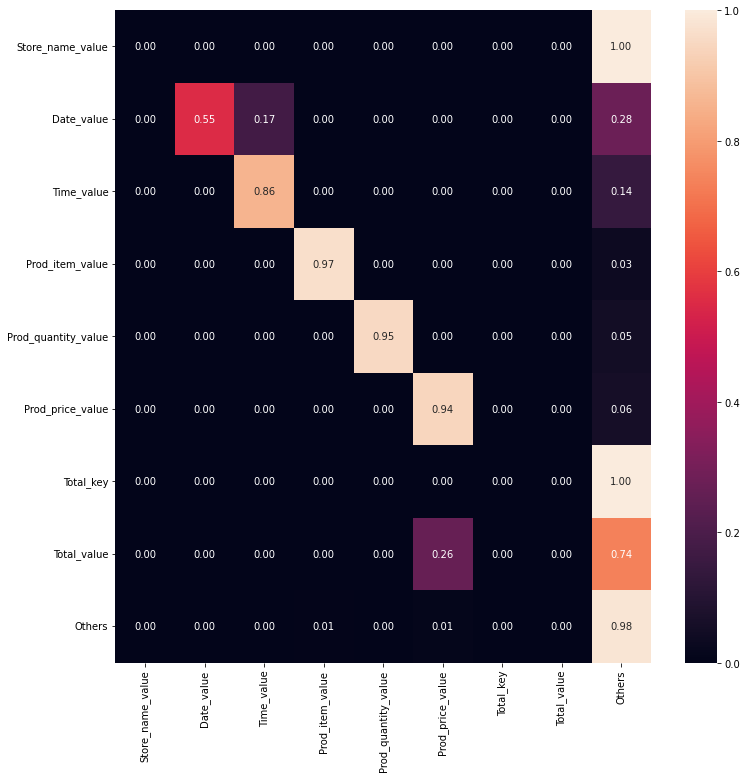

In [337]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(classification_report(y_aktual, y_prediksi, digits=4))

cm = confusion_matrix(y_aktual, y_prediksi)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=[id2label[it] for it in important_labels], yticklabels=[id2label[it] for it in important_labels])

In [328]:
trainer.save_model("Saved_model/only_main_dataset_10epochs")

Saving model checkpoint to Saved_model/only_main_dataset_10epochs
Configuration saved in Saved_model/only_main_dataset_10epochs\config.json
Model weights saved in Saved_model/only_main_dataset_10epochs\pytorch_model.bin
Image processor saved in Saved_model/only_main_dataset_10epochs\preprocessor_config.json
tokenizer config file saved in Saved_model/only_main_dataset_10epochs\tokenizer_config.json
Special tokens file saved in Saved_model/only_main_dataset_10epochs\special_tokens_map.json


In [ ]:
trainer.push_to_hub()

## Inference

In [44]:
model = AutoModelForTokenClassification.from_pretrained("Saved_model/all_data_4epochs")

loading configuration file Saved_model/all_data_4epochs\config.json
Model config LayoutLMv3Config {
  "_name_or_path": "Saved_model/all_data_4epochs",
  "architectures": [
    "LayoutLMv3ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Ignore",
    "1": "Store_name_value",
    "2": "Date_value",
    "3": "Time_value",
    "4": "Prod_item_key",
    "5": "Prod_item_value",
    "6": "Prod_quantity_key",
    "7": "Prod_quantity_value",
    "8": "Prod_price_key",
    "9": "Prod_price_value",
    "10": "Subtotal_key",
    "11": "Subtotal_value",
    "12": "Total_key",
    "13": "Total_value",
    "14": "Others"
  },
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "labe

In [ ]:
def fix_box(bbox, size):
    return [
        int(bbox[0] * size[1] / 1000),
        int(bbox[1] * size[0] / 1000),
        int(bbox[2] * size[1] / 1000),
        int(bbox[3] * size[0] / 1000),
    ]

In [137]:
with open(os.path.join(DIR,'Annotation','20230210_093933.json')) as f:
    data = json.load(f)


In [138]:
inf_path, inf_words, inf_bboxes = data['file_name'],data["words"], data["bboxes"]

In [139]:
images = cv2.imread(os.path.join(DIR,'Nota_Segmented','Batch 1',data['file_name']))
if images is None:
    images = cv2.imread(os.path.join(DIR,'Nota_Segmented','Batch 2',data['file_name']))

if images is None:
    raise Exception(f"File {data['file_name']} not found")

images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
# images = Image.open(os.path.join(DIR,'Nota_Segmented',inf_path)).convert("RGB") #Image.open(examples[image_column_name])
words = inf_words
boxes = inf_bboxes
encoding = processor(images, words, boxes=boxes, return_tensors="pt",truncation=True,padding=True)

for k,v in encoding.items():
  print(k,v.shape)

with torch.no_grad():
  outputs = model(**encoding)

logits = outputs.logits
print(logits.shape)

predictions = logits.argmax(-1).squeeze().tolist()
print(predictions)

input_ids torch.Size([1, 106])
attention_mask torch.Size([1, 106])
bbox torch.Size([1, 106, 4])
pixel_values torch.Size([1, 3, 224, 224])


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


torch.Size([1, 106, 15])
[14, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 3, 3, 3, 14, 14, 14, 14, 14, 5, 5, 5, 5, 5, 5, 7, 14, 14, 14, 14, 5, 5, 5, 5, 5, 5, 7, 14, 14, 14, 14, 5, 5, 5, 5, 5, 7, 14, 14, 14, 14, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 9, 9, 9, 9, 9, 9, 9, 9, 9, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14]


In [140]:
token_boxes = encoding.bbox.squeeze().tolist()

true_predictions = [model.config.id2label[pred] for pred in predictions]
true_boxes = [fix_box(box, images.shape) for box in token_boxes]

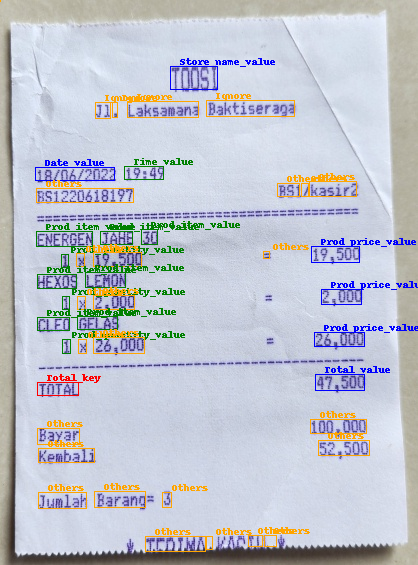

In [141]:
image_pil = Image.fromarray(images)
draw = ImageDraw.Draw(image_pil)

font = ImageFont.load_default()

def iob_to_label(label):
    #label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {
    "Date_key": 'red',
    "Date_value": 'blue',
    "Ignore": 'orange',
    "Others": 'orange',
    "Prod_item_key": 'red',
    "Prod_item_value": 'green',
    "Prod_price_key": 'red',
    "Prod_price_value": 'blue',
    "Prod_quantity_key": 'red',
    "Prod_quantity_value": 'green',
    "Store_addr_key": 'red',
    "Store_addr_value": 'blue',
    "Store_name_key": 'red',
    "Store_name_value": 'blue',
    "Subtotal_key": 'red',
    "Subtotal_value": 'blue',
    "Tax_key": 'red',
    "Tax_value": 'green',
    "Tel_key": 'red',
    "Tel_value": 'green',
    "Time_key": 'red',
    "Time_value": 'green',
    "Tips_key": 'red',
    "Tips_value": 'green',
    "Total_key": 'red',
    "Total_value": 'blue'
  }

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction)
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image_pil.save(os.path.join(DIR,'Result',inf_path))
image_pil

## Inference trial 2

In [9]:
processor = AutoProcessor.from_pretrained("Theivaprakasham/layoutlmv3-finetuned-wildreceipt", apply_ocr=False)

In [54]:
model = model = AutoModelForTokenClassification.from_pretrained("Saved_model/all_data_4epochs")

loading configuration file Saved_model/all_data_4epochs\config.json
Model config LayoutLMv3Config {
  "_name_or_path": "Saved_model/all_data_4epochs",
  "architectures": [
    "LayoutLMv3ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Ignore",
    "1": "Store_name_value",
    "2": "Date_value",
    "3": "Time_value",
    "4": "Prod_item_key",
    "5": "Prod_item_value",
    "6": "Prod_quantity_key",
    "7": "Prod_quantity_value",
    "8": "Prod_price_key",
    "9": "Prod_price_value",
    "10": "Subtotal_key",
    "11": "Subtotal_value",
    "12": "Total_key",
    "13": "Total_value",
    "14": "Others"
  },
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "labe

In [55]:
# define id2label, label2color
labels = dataset['test'].features['ner_tags'].feature.names
id2label = {v: k for v, k in enumerate(labels)}
label2color = {
    "Date_key": 'red',
    "Date_value": 'blue',
    "Ignore": 'orange',
    "Others": 'orange',
    "Prod_item_key": 'red',
    "Prod_item_value": 'green',
    "Prod_price_key": 'red',
    "Prod_price_value": 'blue',
    "Prod_quantity_key": 'red',
    "Prod_quantity_value": 'green',
    "Store_addr_key": 'red',
    "Store_addr_value": 'blue',
    "Store_name_key": 'red',
    "Store_name_value": 'blue',
    "Subtotal_key": 'red',
    "Subtotal_value": 'blue',
    "Tax_key": 'red',
    "Tax_value": 'green',
    "Tel_key": 'red',
    "Tel_value": 'green',
    "Time_key": 'red',
    "Time_value": 'green',
    "Tips_key": 'red',
    "Tips_value": 'green',
    "Total_key": 'red',
    "Total_value": 'blue'
  }

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]


def iob_to_label(label):
    return label



def process_image(filepath):
    filename = filepath.split('/')[-1].split('//')[-1].split('\\')[-1]
    image = Image.open(filepath).convert("RGB")
    print(type(image))
    width, height = image.size

    with open(os.path.join(DIR,'annotation.json')) as f:
        data = json.load(f)

    inf_data = data[filename]
    inf_path, inf_words, inf_bboxes = inf_data['file_name'],inf_data["words"], inf_data["bboxes"]
    
    words = inf_words
    boxes = inf_bboxes

    # encode
    # encoding = processor(image, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    encoding = processor(image, inf_words, boxes=inf_bboxes, return_tensors="pt",truncation=True,padding=True)

    # forward pass
    with torch.no_grad():
        outputs = model(**encoding)

    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()

    # only keep non-subword predictions
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions)]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes)]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction)
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
        
    image.save(os.path.join(DIR,'Result',inf_path))
    return image

In [31]:
for filename in os.listdir('Nota_Segmented'):
    try:
        if filename != '20221013_194642.jpg':
            process_image(os.path.join('Nota_Segmented',filename))
    except:
        print(filename," has a problem")

<class 'PIL.Image.Image'>


c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:763: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
20221013_192902.jpg  has a problem
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<class 'PIL.Image.Image'>
<cl